In [1]:

from collections import defaultdict
import itertools
import os
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from matminer.datasets import load_dataset
from pymatgen.core import Composition



# Data exploration

In [2]:
df = load_dataset("matbench_dielectric")

In [3]:
from matminer.datasets import get_all_dataset_info

# Get dataset info from matminer
info = get_all_dataset_info("matbench_dielectric")

# Check out the info about the dataset.
print(info)

Dataset: matbench_dielectric
Description: Matbench v0.1 test dataset for predicting refractive index from structure. Adapted from Materials Project database. Removed entries having a formation energy (or energy above the convex hull) more than 150meV and those having refractive indices less than 1 and those containing noble gases. Retrieved April 2, 2019. For benchmarking w/ nested cross validation, the order of the dataset must be identical to the retrieved data; refer to the Automatminer/Matbench publication for more details.
Columns:
	n: Target variable. Refractive index (unitless).
	structure: Pymatgen Structure of the material.
Num Entries: 4764
Reference: Petousis, I., Mrdjenovich, D., Ballouz, E., Liu, M., Winston, D.,
Chen, W., Graf, T., Schladt, T. D., Persson, K. A. & Prinz, F. B.
High-throughput screening of inorganic compounds for the discovery
of novel dielectric and optical materials. Sci. Data 4, 160134 (2017).
Bibtex citations: ["@Article{Dunn2020,\nauthor={Dunn, Alexan

In [4]:
df.columns

Index(['structure', 'n'], dtype='object')

# Target space

In [5]:
df.describe()

,n
count,4764.000000
mean,2.428314
std,2.101722
min,1.000000
25%,1.684573
50%,2.060778
75%,2.595320
max,62.062998


Text(0.5, 0, 'n')

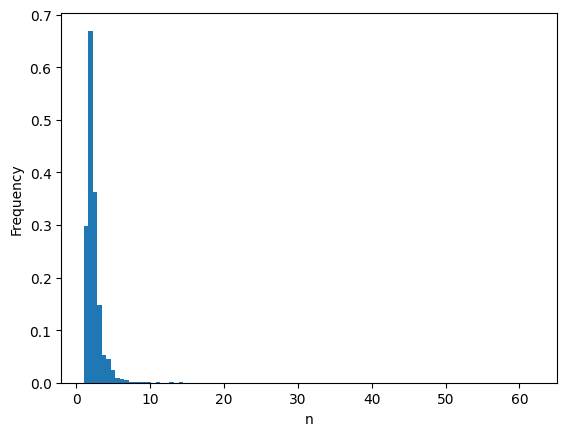

In [7]:
fig, ax = plt.subplots(facecolor="w")
ax.hist(df["n"], bins=100, density=True);
ax.set_ylabel("Frequency")
ax.set_xlabel("n")

/home/tangcheng/anaconda3/envs/aniso/lib/python3.9/site-packages/emmet/core/__init__.py:5: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
/home/tangcheng/anaconda3/envs/aniso/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2025-11-12 20:08:41 INFO     Initialized benchmark 'matbench_v0.1' with 1 tasks: 
['matbench_dielectric']
Loading and analyzing dataset...
2025-11-12 20:08:41 INFO     Loading dataset 'matbench_dielectric'...
2025-11-12 20:08:44 INFO     Dataset 'matbench_dielectric loaded.


Processing fold 0 training data:   0%|          | 0/3811 [00:00<?, ?it/s]/home/tangcheng/anaconda3/envs/aniso/lib/python3.9/site-packages/pymatgen/symmetry/analyzer.py:179: DeprecationWarning: dict interface is deprecated. Use attribute interface instead
  n = self._space_group_data["number"]
Processing fold 0 training data:  10%|▉         | 371/3811 [00:00<00:07, 457.77it/s]spglib: ssm_get_exact_positions failed.
spglib: get_bravais_exact_positions_and_lattice failed.
spglib: ssm_get_exact_positions failed.
spglib: get_bravais_exact_positions_and_lattice failed.
Processing fold 0 training data:  40%|███▉      | 1514/3811 [00:02<00:04, 496.32it/s]spglib: ssm_get_exact_positions failed.
spglib: get_bravais_exact_positions_and_lattice failed.
Processing fold 1 training data:   0%|          | 0/3811 [00:00<?, ?it/s]/home/tangcheng/anaconda3/envs/aniso/lib/python3.9/site-packages/pymatgen/symmetry/analyzer.py:179: DeprecationWarning: dict interface is deprecated. Use attribute interface in


Crystal system distribution statistics:


,Count,Percentage(%)
crystal_system,,
Triclinic,1865.0,7.83
Monoclinic,3820.0,16.04
Orthorhombic,5635.0,23.66
Tetragonal,3975.0,16.69
Trigonal,3575.0,15.01
Hexagonal,2005.0,8.42
Cubic,2945.0,12.36
Unknown,NaN,NaN
Error,NaN,NaN


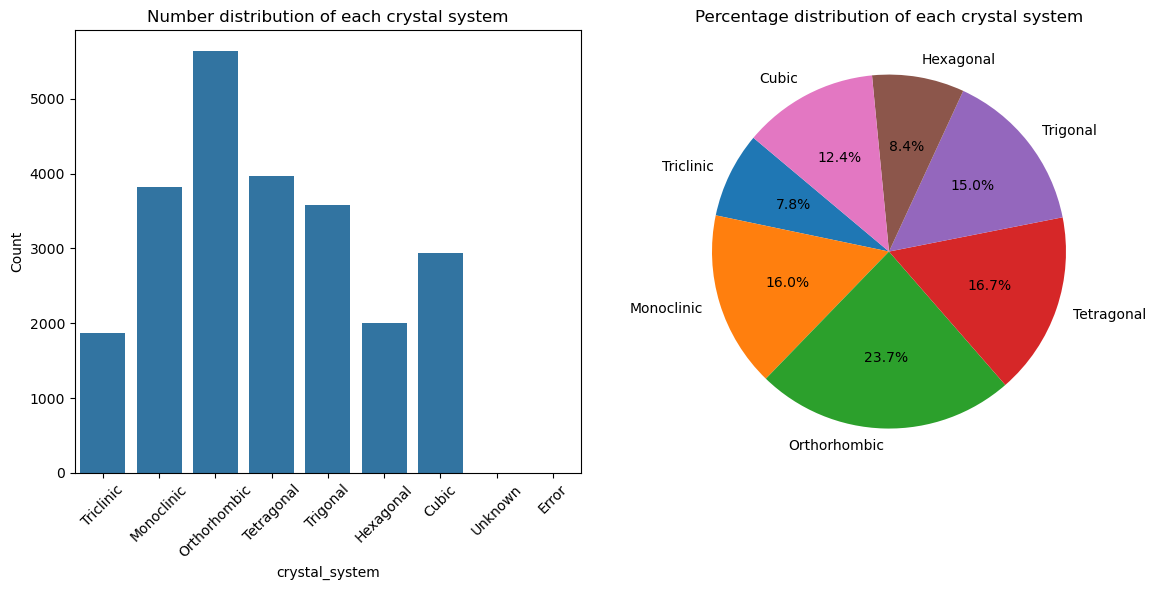

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matbench.bench import MatbenchBenchmark
from pymatgen.core import Structure
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from tqdm import tqdm

# Set matplotlib to display in Notebook
%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 6)  # Set default figure size

# Define crystal system list
CRYSTAL_SYSTEMS = ["Triclinic", "Monoclinic", "Orthorhombic", 
                   "Tetragonal", "Trigonal", "Hexagonal", "Cubic"]

def structure_to_crystal_system(pmg_struct, symprec=0.01):
    """Convert pymatgen structure to crystal system"""
    try:
        cs = SpacegroupAnalyzer(pmg_struct, symprec=symprec).get_crystal_system().capitalize()
        # Special handling for rhombohedral, classified as trigonal
        if cs.lower() == "rhombohedral":
            cs = "Trigonal"
        if cs not in CRYSTAL_SYSTEMS:
            print(f"Warning: unknown crystal system found {cs}")
            return "Unknown"
        return cs
    except Exception as e:
        print(f"Error in analyzing structure: {e}")
        return "Error"

def analyze_crystal_systems():
    """Analyze crystal system distribution in matbench_dielectric dataset"""
    # Load dataset
    mb = MatbenchBenchmark(subset=['matbench_dielectric'], autoload=False)
    
    # Store all crystal system information
    all_crystal_systems = []
    all_formulas = []
    
    print("Loading and analyzing dataset...")
    for task in mb.tasks:
        task.load()
        
        # Collect all folds of training and test data
        for fold in task.folds:
            # Get training data
            X_train, _ = task.get_train_and_val_data(fold)
            # Get test data
            X_test = task.get_test_data(fold, include_target=False)
            
            # Process training data
            for s in tqdm(X_train, desc=f"Processing fold {fold} training data"):
                if isinstance(s, Structure):
                    cs = structure_to_crystal_system(s)
                    all_crystal_systems.append(cs)
                    all_formulas.append(s.composition.reduced_formula)
            
            # Process test data
            for s in tqdm(X_test, desc=f"Processing fold {fold} test data"):
                if isinstance(s, Structure):
                    cs = structure_to_crystal_system(s)
                    all_crystal_systems.append(cs)
                    all_formulas.append(s.composition.reduced_formula)
    
    # Create dataframe
    df = pd.DataFrame({
        "formula": all_formulas,
        "crystal_system": all_crystal_systems
    })
    
    # Count each crystal system
    count = df['crystal_system'].value_counts()
    # Calculate percentage
    percentage = df['crystal_system'].value_counts(normalize=True) * 100
    
    # Combine results
    stats = pd.DataFrame({
        'Count': count,
        'Percentage(%)': percentage.round(2)
    })
    
    # Sort by preset order
    stats = stats.reindex(CRYSTAL_SYSTEMS + ["Unknown", "Error"])
    
    print("\nCrystal system distribution statistics:")
    display(stats)  # Use Notebook's display function to show dataframe
    
    # Visualization
    fig, (ax1, ax2) = plt.subplots(1, 2)
    
    # Bar chart
    sns.barplot(x=stats.index, y='Count', data=stats, ax=ax1)
    ax1.set_title('Number distribution of each crystal system')
    ax1.tick_params(axis='x', rotation=45)
    
    # Pie chart
    # Only show major categories, merge others into "Other"
    threshold = 1  # Percentage threshold
    other_percent = stats[stats['Percentage(%)'] < threshold]['Percentage(%)'].sum()
    main_categories = stats[stats['Percentage(%)'] >= threshold]
    
    if other_percent > 0:
        main_categories.loc['Other'] = [0, other_percent]
    
    ax2.pie(main_categories['Percentage(%)'], labels=main_categories.index, 
            autopct='%1.1f%%', startangle=140)
    ax2.set_title('Percentage distribution of each crystal system')
    
    plt.tight_layout()
    plt.show()  # Display chart in Notebook
    
    return df, stats

# Run analysis directly in Notebook
df, stats = analyze_crystal_systems()
    

# 验证集

### 先把训练折里的 DataFrame 依 crystal_system 分组。
##
### 每个晶系内随机打乱（种子 seed=42），按比例取 val_ratio=0.05 进验证集，其余进训练集。
##
### 不触碰测试集 Matbench 每个 fold 自带官方 train/test 划分；分层切分只发生在该 fold 的训练部分，因此不存在信息泄漏到 test。


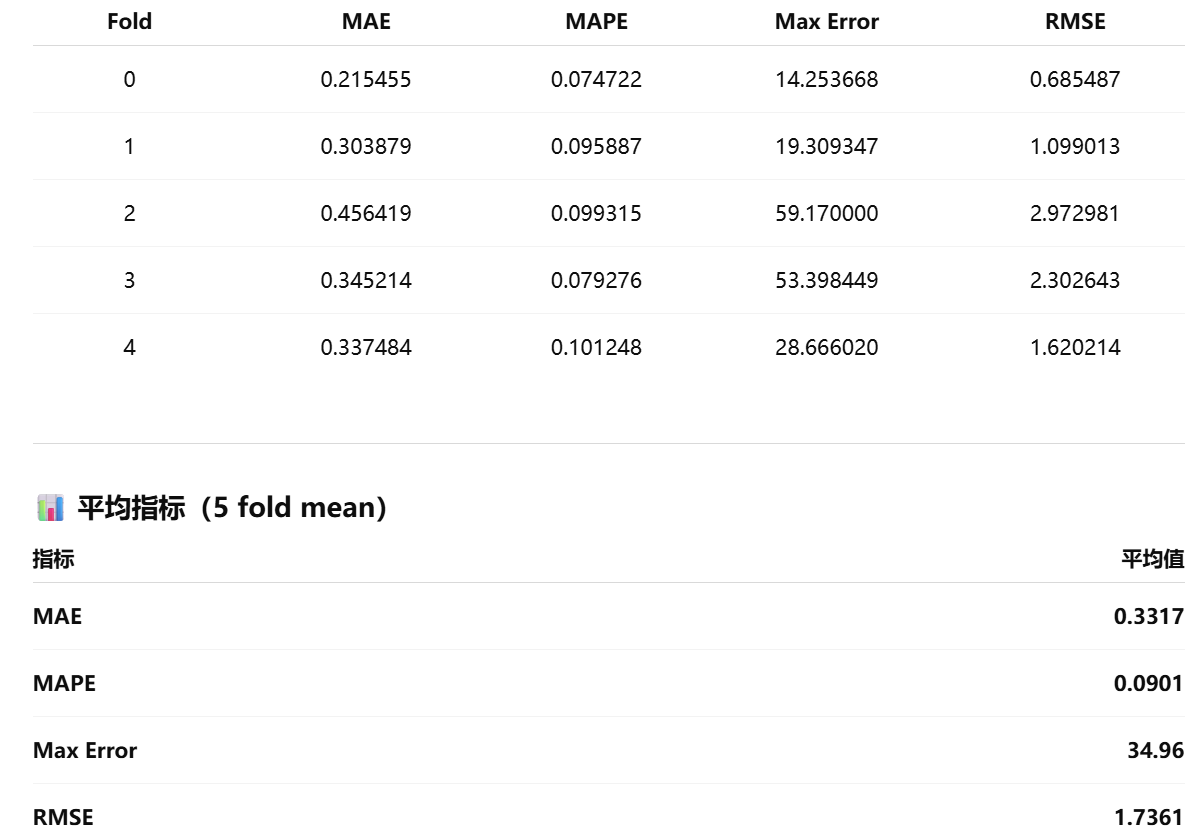

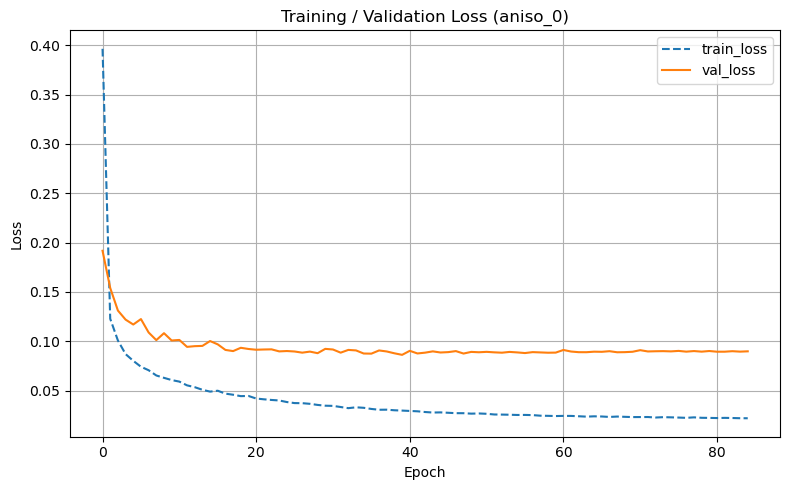

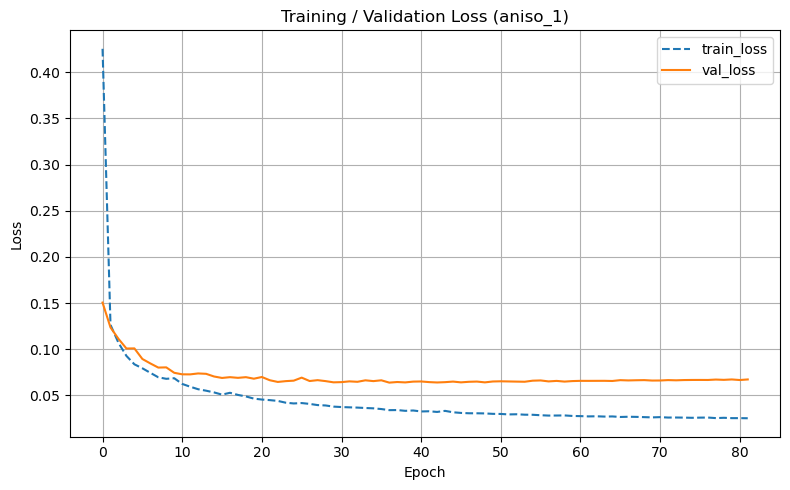

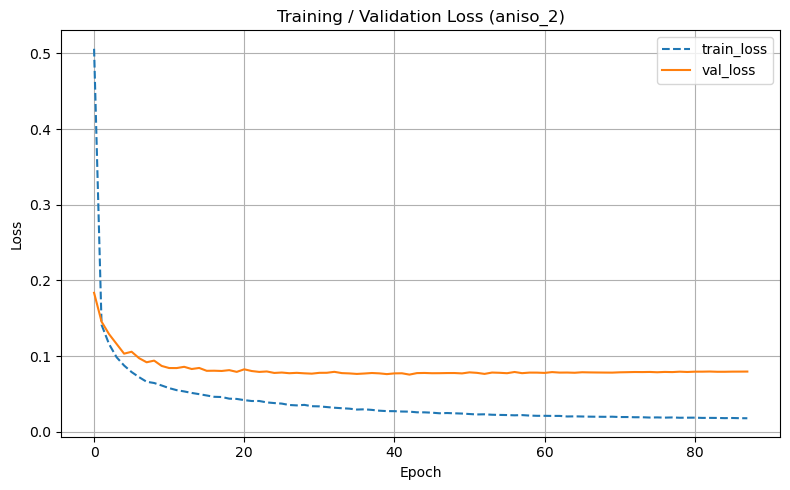

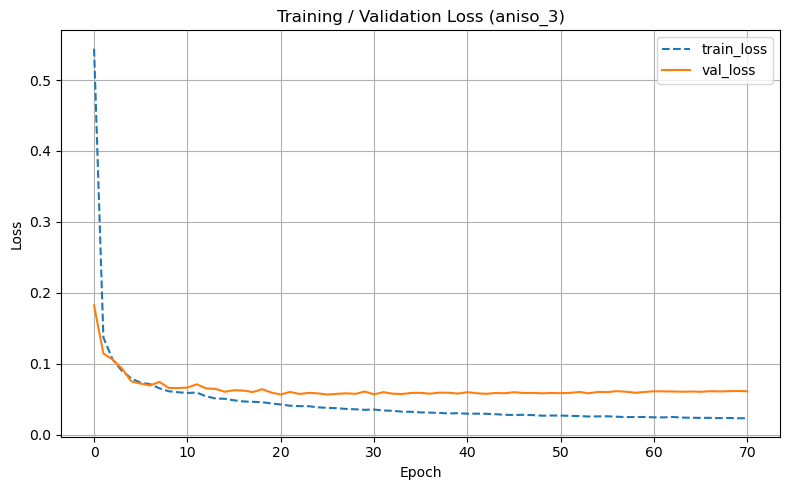

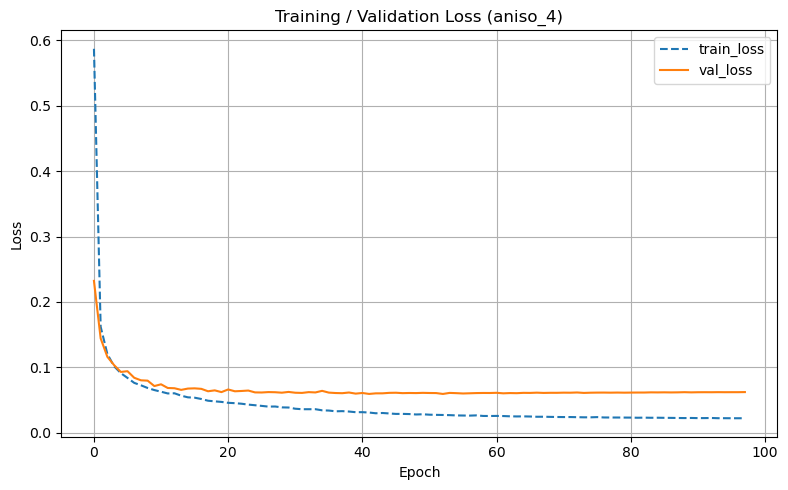


Fold summary (best val epoch per run):
algorithm (fold)  mean MAE  mean RMSE  max error
          fold_0    0.4402     2.1586        NaN
          fold_1    0.2335     0.6206        NaN
          fold_2    0.4609     3.2747        NaN
          fold_3    0.2142     0.6502        NaN
          fold_4    0.2610     1.4750        NaN

✅ 保存到: /home/tangcheng/an/matbench_v0.1_AnisoTensorNet_9_22/logs/fold_summary.csv


In [13]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# === 你的 CSV 文件列表 ===
base = Path("/home/tangcheng/an/matbench_v0.1_AnisoTensorNet_9_22/logs")
runs = [f"aniso_{i}" for i in range(5)]  # aniso_0 ... aniso_4
csv_paths = [base / run / "version_0" / "metrics.csv" for run in runs]

def last_valid(series: pd.Series):
    s = series.dropna()
    return s.iloc[-1] if not s.empty else np.nan

# ==== 兼容不同命名的工具 ====
def pick_col(df: pd.DataFrame, candidates):
    """在 df 里返回第一个存在的列名（忽略大小写与下划线/连字符差异）"""
    norm = {re.sub(r'[^a-z0-9]', '', c.lower()): c for c in df.columns}
    for cand in candidates:
        key = re.sub(r'[^a-z0-9]', '', cand.lower())
        if key in norm:
            return norm[key]
    return None

def best_epoch_row(agg: pd.DataFrame):
    """
    选择‘最优’epoch那一行：
      1) 优先 val_loss 最小
      2) 其次 val_mae 最小
      3) 否则取最后一行
    """
    val_loss_col = pick_col(agg, ["val_loss", "valid_loss", "validation_loss"])
    val_mae_col  = pick_col(agg, ["val_mae", "val_MAE", "valid_mae", "validation_mae"])

    if val_loss_col and agg[val_loss_col].notna().any():
        idx = agg[val_loss_col].astype(float).idxmin()
        return agg.loc[idx]
    if val_mae_col and agg[val_mae_col].notna().any():
        idx = agg[val_mae_col].astype(float).idxmin()
        return agg.loc[idx]
    return agg.iloc[-1]

def fold_sort_key(s: pd.Series) -> pd.Series:
    # 提取字符串里的数字，如 'fold_3' -> 3；失败的设成一个很大的数放到最后
    num = pd.to_numeric(s.astype(str).str.extract(r'(\d+)', expand=False), errors="coerce")
    return num.fillna(10**9).astype(int)

# ============ 画每个 run 的 loss 曲线 ============ #
for run, csv_path in zip(runs, csv_paths):
    if not csv_path.exists():
        print(f"⚠️ 文件不存在: {csv_path}")
        continue

    # 1) 读取并数值化
    df = pd.read_csv(csv_path)
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

    # 2) 兜底 epoch/step，并过滤无效行
    if "epoch" not in df.columns:
        df["epoch"] = np.arange(len(df), dtype=int)
    if "step" not in df.columns:
        df["step"] = -1
    else:
        df["step"] = df["step"].fillna(-1)

    metric_cols = [c for c in df.columns if c not in ("epoch", "step")]
    df = df[df[metric_cols].notna().any(axis=1)].copy()
    df = df.sort_values(["epoch", "step"])

    # 3) 每个 epoch 取“最后一次记录”的指标
    agg = df.groupby("epoch", as_index=False).agg(last_valid)

    # 4) 绘制单独图
    x = agg["epoch"].astype(int)
    has_train = "train_loss" in agg.columns and agg["train_loss"].notna().any()
    has_val   = "val_loss"   in agg.columns and agg["val_loss"].notna().any()

    plt.figure(figsize=(8,5))
    if has_train:
        plt.plot(x, agg["train_loss"], label="train_loss", linestyle="--")
    if has_val:
        plt.plot(x, agg["val_loss"], label="val_loss")

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Training / Validation Loss ({run})")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# ============ 汇总表：mean MAE / mean RMSE / max error（取最优验证 epoch） ============ #
summary_rows = []

for run, csv_path in zip(runs, csv_paths):
    if not csv_path.exists():
        print(f"⚠️ 文件不存在: {csv_path}")
        continue

    df = pd.read_csv(csv_path)
    # 数值化
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")
    if "epoch" not in df.columns:
        df["epoch"] = np.arange(len(df), dtype=int)
    if "step" not in df.columns:
        df["step"] = -1
    else:
        df["step"] = df["step"].fillna(-1)

    metric_cols = [c for c in df.columns if c not in ("epoch", "step")]
    df = df[df[metric_cols].notna().any(axis=1)].copy()
    df = df.sort_values(["epoch", "step"])
    if df.empty:
        continue

    agg = df.groupby("epoch", as_index=False).agg(last_valid)
    if agg.empty:
        continue

    row = best_epoch_row(agg)  # 取最优epoch的那一行

    # 列名适配
    mae_col  = pick_col(agg, ["val_mae", "val_MAE", "valid_mae", "validation_mae"])
    rmse_col = pick_col(agg, ["val_rmse", "val_RMSE", "valid_rmse", "validation_rmse"])
    mse_col  = pick_col(agg, ["val_mse", "valid_mse", "validation_mse"])
    maxe_col = pick_col(agg, ["val_max_error", "val_max_abs_err", "val_max_err", "valid_max_error"])

    # 计算三个指标
    mean_mae  = float(row[mae_col]) if mae_col and pd.notna(row[mae_col]) else np.nan
    if rmse_col and pd.notna(row[rmse_col]):
        mean_rmse = float(row[rmse_col])
    elif mse_col and pd.notna(row[mse_col]):
        mean_rmse = float(np.sqrt(row[mse_col]))
    else:
        mean_rmse = np.nan
    max_err   = float(row[maxe_col]) if maxe_col and pd.notna(row[maxe_col]) else np.nan

    summary_rows.append({
        "algorithm (fold)": run.replace("aniso_", "fold_"),
        "mean MAE":  mean_mae,
        "mean RMSE": mean_rmse,
        "max error": max_err,
    })

# === 汇总表 ===
summary_df = pd.DataFrame(summary_rows)

if summary_df.empty:
    print("\n⚠️ 没有从任何 metrics.csv 中提取到有效指标，请检查日志列名是否存在（例如 val_mae/val_rmse/val_loss）。")
else:
    # 排序：fold_0..fold_4   ← 修正点：使用 expand=False 返回 Series，避免 DataFrame 导致的 ValueError
    summary_df = summary_df.sort_values(by="algorithm (fold)", key=fold_sort_key)

    # 漂亮一点的打印
    pd.set_option("display.float_format", lambda v: f"{v:.4f}")
    print("\nFold summary (best val epoch per run):")
    print(summary_df.to_string(index=False))

    # 如需保存
    out_csv = base / "fold_summary.csv"
    summary_df.to_csv(out_csv, index=False)
    print(f"\n✅ 保存到: {out_csv}")


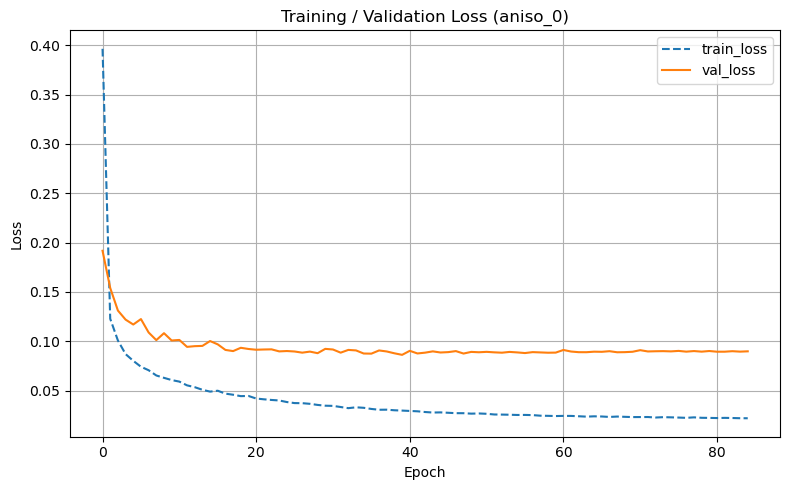

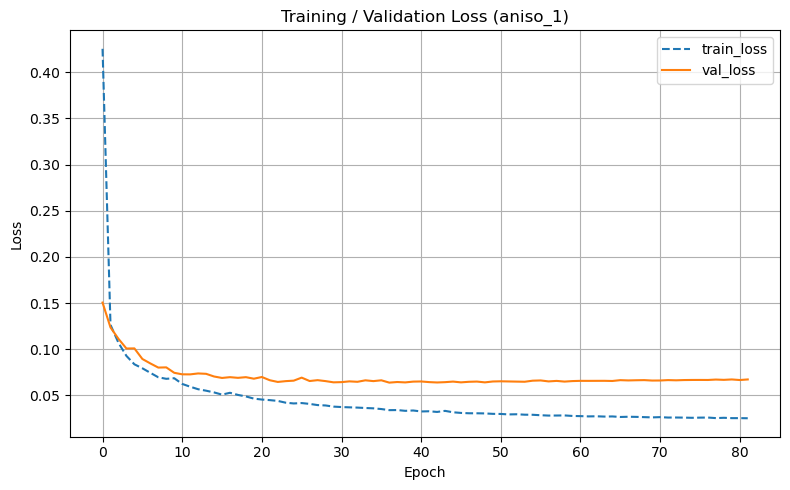

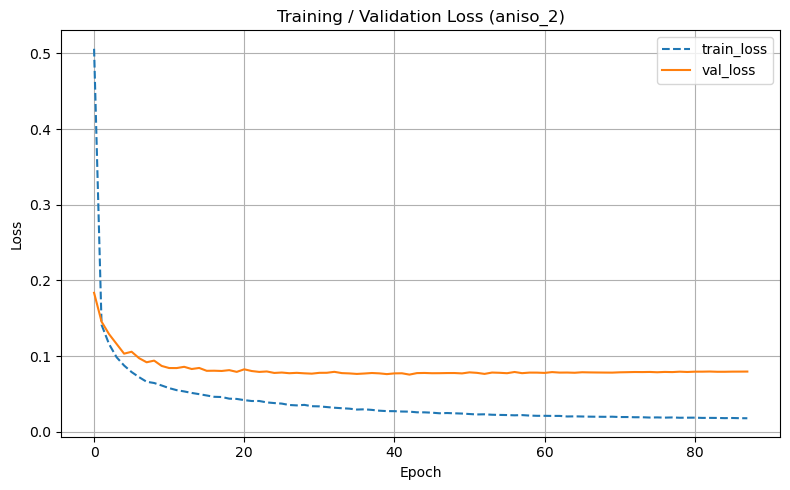

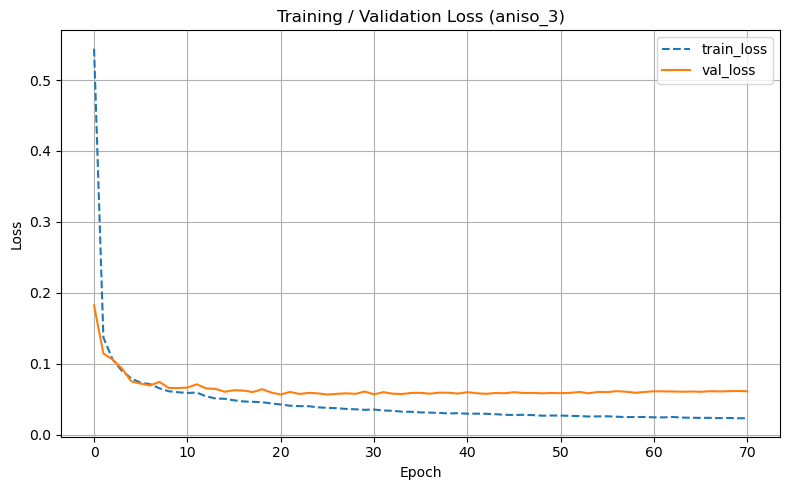

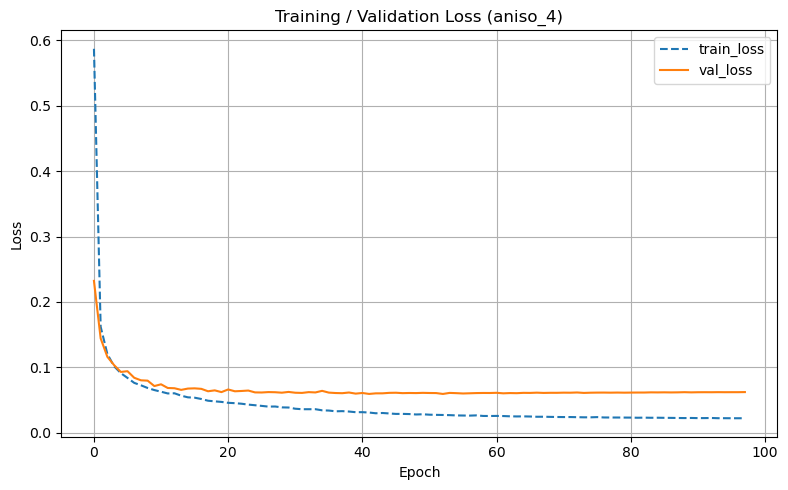

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# === 你的 CSV 文件列表 ===
base = Path("/home/tangcheng/an/matbench_v0.1_AnisoTensorNet_9_22/logs")
runs = [f"aniso_{i}" for i in range(5)]  # aniso_0 ... aniso_4
csv_paths = [base / run / "version_0" / "metrics.csv" for run in runs]

def last_valid(series: pd.Series):
    s = series.dropna()
    return s.iloc[-1] if not s.empty else np.nan

for run, csv_path in zip(runs, csv_paths):
    if not csv_path.exists():
        print(f"⚠️ 文件不存在: {csv_path}")
        continue

    # 1) 读取并数值化
    df = pd.read_csv(csv_path)
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

    # 2) 兜底 epoch/step，并过滤无效行
    if "epoch" not in df.columns:
        df["epoch"] = np.arange(len(df), dtype=int)
    if "step" not in df.columns:
        df["step"] = -1
    else:
        df["step"] = df["step"].fillna(-1)

    metric_cols = [c for c in df.columns if c not in ("epoch", "step")]
    df = df[df[metric_cols].notna().any(axis=1)].copy()
    df = df.sort_values(["epoch", "step"])

    # 3) 每个 epoch 取“最后一次记录”的指标
    agg = df.groupby("epoch", as_index=False).agg(last_valid)

    # 4) 绘制单独图
    x = agg["epoch"].astype(int)
    has_train = "train_loss" in agg.columns and agg["train_loss"].notna().any()
    has_val   = "val_loss"   in agg.columns and agg["val_loss"].notna().any()

    plt.figure(figsize=(8,5))
    if has_train:
        plt.plot(x, agg["train_loss"], label="train_loss", linestyle="--")
    if has_val:
        plt.plot(x, agg["val_loss"], label="val_loss")

    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Training / Validation Loss ({run})")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


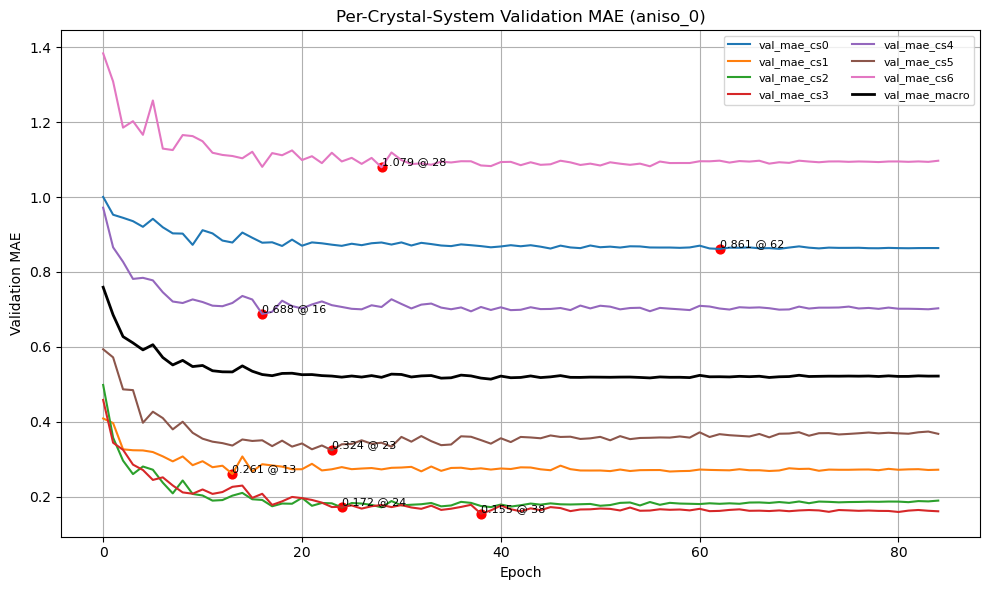

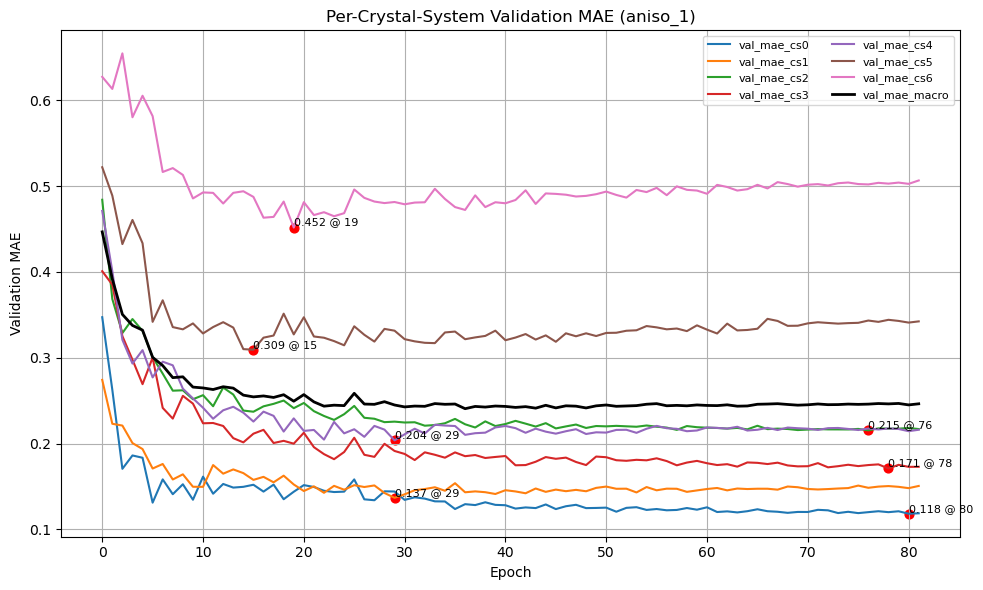

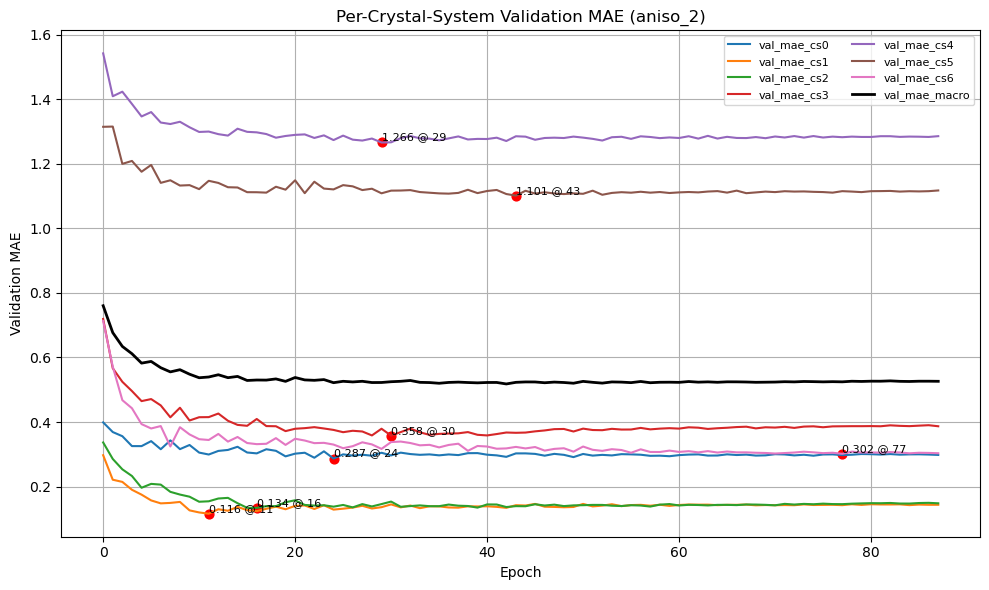

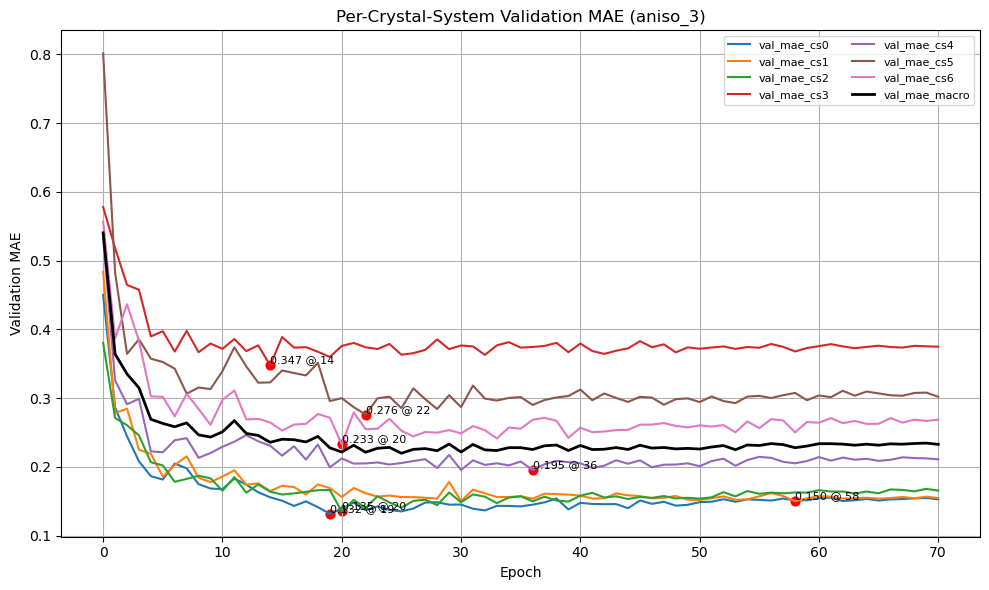

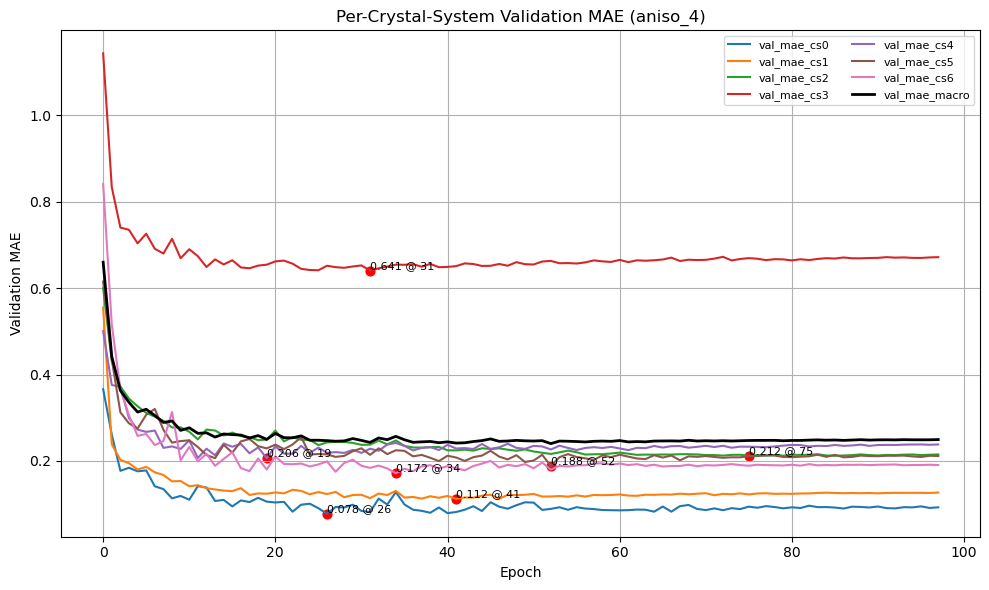

In [9]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# === 你的 CSV 文件列表 ===
base = Path("/home/tangcheng/an/matbench_v0.1_AnisoTensorNet_9_22/logs")
runs = [f"aniso_{i}" for i in range(5)]  # aniso_0 ... aniso_4
csv_paths = [base / run / "version_0" / "metrics.csv" for run in runs]

def last_valid(series: pd.Series):
    s = series.dropna()
    return s.iloc[-1] if not s.empty else np.nan

for run, csv_path in zip(runs, csv_paths):
    if not csv_path.exists():
        print(f"⚠️ 文件不存在: {csv_path}")
        continue

    # 1) 读取并数值化
    df = pd.read_csv(csv_path)
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

    # 2) 兜底 epoch/step，并过滤无效行
    if "epoch" not in df.columns:
        df["epoch"] = np.arange(len(df), dtype=int)
    if "step" not in df.columns:
        df["step"] = -1
    else:
        df["step"] = df["step"].fillna(-1)

    metric_cols = [c for c in df.columns if c not in ("epoch", "step")]
    df = df[df[metric_cols].notna().any(axis=1)].copy()
    df = df.sort_values(["epoch", "step"])

    # 3) 每个 epoch 取“最后一次记录”的指标
    agg = df.groupby("epoch", as_index=False).agg(last_valid)
    x = agg["epoch"].astype(int)

    # === 分晶系验证 MAE + 宏平均 ===
    cs_cols = [c for c in agg.columns if c.startswith("val_mae_cs")]
    if cs_cols:
        plt.figure(figsize=(10,6))

        # 分晶系曲线
        for cs in cs_cols:
            series = agg[cs].dropna()
            if series.empty:
                continue
            plt.plot(x, agg[cs], label=cs)

            # 标记最优点
            best_epoch = series.idxmin()
            best_val = series.min()
            plt.scatter(x[best_epoch], best_val, marker="o", color="red", s=40)
            plt.text(
                x[best_epoch], best_val,
                f"{best_val:.3f} @ {x[best_epoch]}",
                fontsize=8, ha="left", va="bottom"
            )

        # 宏平均曲线
        if "val_mae_macro" in agg.columns:
            plt.plot(x, agg["val_mae_macro"], label="val_mae_macro", color="black", linewidth=2)

        plt.xlabel("Epoch")
        plt.ylabel("Validation MAE")
        plt.title(f"Per-Crystal-System Validation MAE ({run})")
        plt.legend(loc="upper right", ncol=2, fontsize=8)
        plt.grid(True)
        plt.tight_layout()
        plt.show()


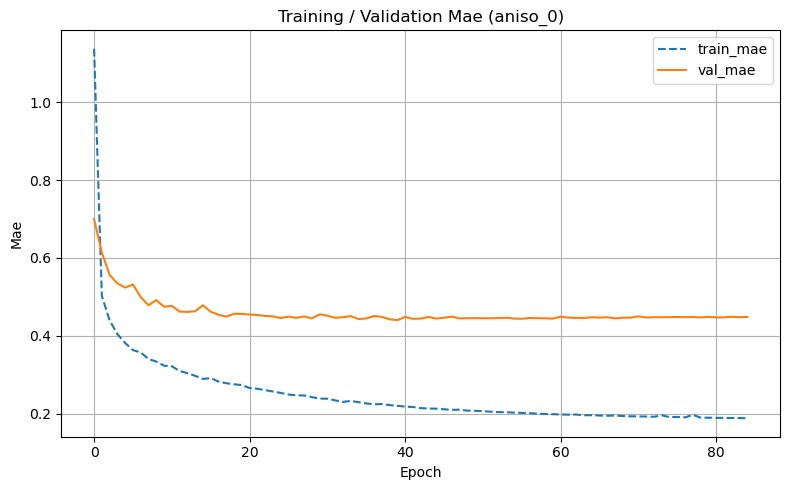

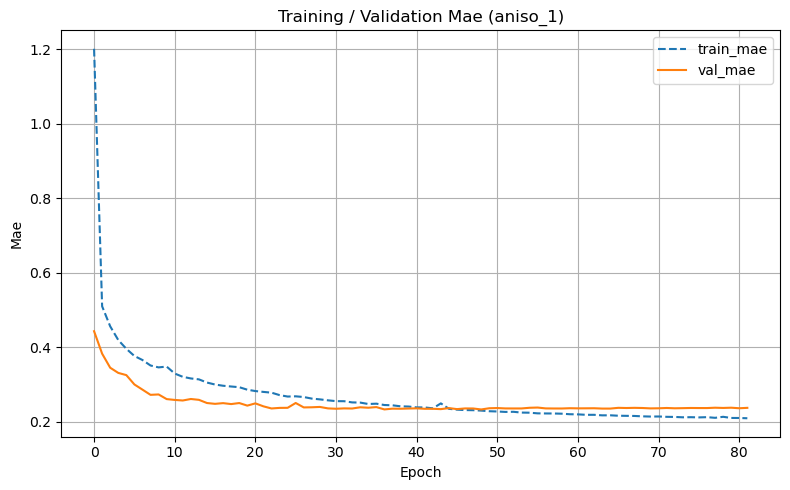

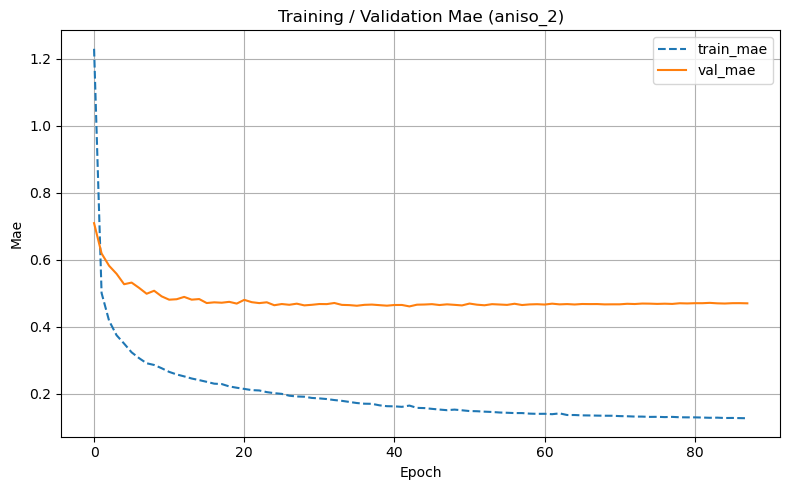

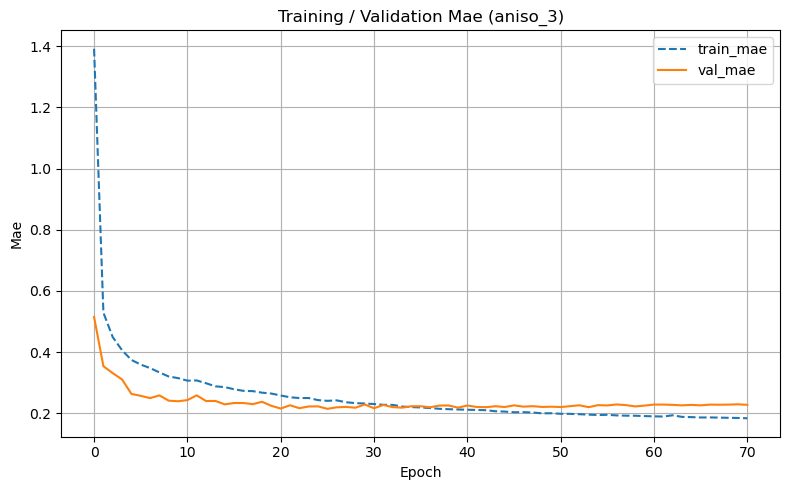

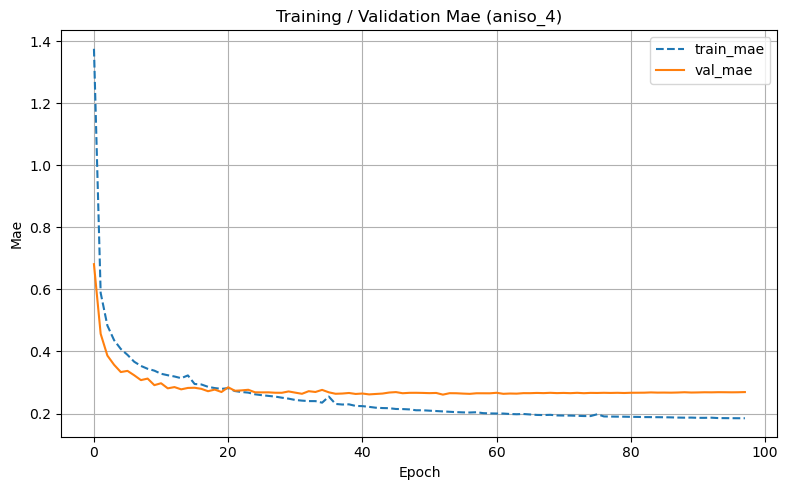

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# === 你的 CSV 文件列表 ===
base = Path("/home/tangcheng/an/matbench_v0.1_AnisoTensorNet_9_22/logs")
runs = [f"aniso_{i}" for i in range(5)]  # aniso_0 ... aniso_4
csv_paths = [base / run / "version_0" / "metrics.csv" for run in runs]

def last_valid(series: pd.Series):
    s = series.dropna()
    return s.iloc[-1] if not s.empty else np.nan

for run, csv_path in zip(runs, csv_paths):
    if not csv_path.exists():
        print(f"⚠️ 文件不存在: {csv_path}")
        continue

    # 1) 读取并数值化
    df = pd.read_csv(csv_path)
    for col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

    # 2) 兜底 epoch/step，并过滤无效行
    if "epoch" not in df.columns:
        df["epoch"] = np.arange(len(df), dtype=int)
    if "step" not in df.columns:
        df["step"] = -1
    else:
        df["step"] = df["step"].fillna(-1)

    metric_cols = [c for c in df.columns if c not in ("epoch", "step")]
    df = df[df[metric_cols].notna().any(axis=1)].copy()
    df = df.sort_values(["epoch", "step"])

    # 3) 每个 epoch 取“最后一次记录”的指标
    agg = df.groupby("epoch", as_index=False).agg(last_valid)

    # 4) 绘制单独图
    x = agg["epoch"].astype(int)
    has_train = "train_mae" in agg.columns and agg["train_mae"].notna().any()
    has_val   = "val_mae"   in agg.columns and agg["val_mae"].notna().any()

    plt.figure(figsize=(8,5))
    if has_train:
        plt.plot(x, agg["train_mae"], label="train_mae", linestyle="--")
    if has_val:
        plt.plot(x, agg["val_mae"], label="val_mae")

    plt.xlabel("Epoch")
    plt.ylabel("Mae")
    plt.title(f"Training / Validation Mae ({run})")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

